In [1]:
import h5py
import numpy as np
from astro_dl_main.data.image_mapper import ImageMapper
#from dl1_data_handler.image_mapper import ImageMapper
import matplotlib.pyplot as plt
#from data import manage
import numpy as np
import os.path
import inspect
import json
import tables


class DataManager():
    """ Data class used to manage the HDF5 data files (simulations + Auger data).
        data_path: data_path of HDF5 file, (hint: use blosc compression to ensure adequate decompression speed,
        to mitigate training bottleneck due to a slow data pipeline)
        params:
            data_path = path to HDF5 datset
        optional params:
            stats: data statistics (stats.json - needed for scaling the dataset)
            tasks: list of tasks to be included (default: ['axis', 'core', 'energy', 'xmax'])
            generator_fn: generator function used for looping over data, generator function needs to have indices and
                          shuffle args.
            ad_map_fn: "advanced mapping function" the function used to map the final dataset. Here an additional
                       preprocessing can be implemented which is mapped during training on the
                       cpu (based on tf.data.experimental.map_and_batch)
    """

    def __init__(self, data_path, stats=None, tasks=['axis', 'impact', 'energy', 'classification']):
        ''' init of DataManager class, to manage simulated (CORSIKA/Offline) and measured dataset '''
        np.random.seed(1)
        self.data_path = data_path

    def open_ipython(self):
        from IPython import embed
        embed()

    @property
    def is_data(self):
        return self.type == "Data"

    @property
    def is_mc(self):
        return self.type == "MC"

    def get_h5_file(self):
        return h5py.File(self.data_path, "r")

    def walk_tree(self, details=True):
        """ Draw the tree of yout HDF5 file to see the hierachy of your dataset
            params: detail(activate details to see shapes and used compression ops, Default: True)
        """

        def walk(file, iter_str=''):
            try:
                keys = file.keys()
            except AttributeError:
                keys = []

            for key in keys:
                try:
                    if details:
                        file[key].dtype
                        print(iter_str + str(file[key]))
                    else:
                        print(iter_str + key)
                except AttributeError:
                    print(iter_str + key)
                    walk(file[key], "   " + iter_str)

        with h5py.File(self.data_path, "r") as file:
            print("filename:", file.filename)
            for key in file.keys():
                print(' - ' + key)
                walk(file[key], iter_str='   - ')

    def extract_info(self, path):
        with self.get_h5_file() as f:
            data = f[path]
            y = np.stack(data[:].tolist())

        return {k: y[:, i] for i, k in enumerate(data.dtype.names)}, dict(data.dtype.descr)

    def make_mc_data(self):
        return self.extract_info("simulation/event/subarray/shower")


In [7]:
def make_hess_geometry(file=None):
    # quick fix for dl1 data handler to circumvent to use ctapipe
    if file is None:
        with open(os.path.join(os.getcwd(), "geometry2d3.json")) as f: 
            attr_dict = json.load(f)

        data_ct14 = attr_dict["ct14_geo"]
        data_ct5 = attr_dict["ct5_geo"]
    else:
        data_ct14 = file["configuration/instrument/telescope/camera/geometry_0"][:].tolist()
        data_ct5 = file["configuration/instrument/telescope/camera/geometry_1"][:].tolist()

    class Geometry():
        def __init__(self, data):
            self.pix_id, self.pix_x, self.pix_y, self.pix_area = np.stack(data).T.astype(np.float32)
            self.pos_x = self.pix_x
            self.pos_y = self.pix_y

        def get_pix_pos(self):
            return np.column_stack([self.pix_x, self.pix_y]).T

    return Geometry(data_ct14), Geometry(data_ct5)

def get_current_path():
    filename = inspect.getframeinfo(inspect.currentframe()).filename
    return os.path.dirname(os.path.abspath(filename))


def rotate(pix_pos, rotation_angle=0):
    rotation_angle = rotation_angle * np.pi / 180.0
    rotation_matrix = np.matrix([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                                 [np.sin(rotation_angle), np.cos(rotation_angle)], ], dtype=float)

    pixel_positions = np.squeeze(np.asarray(np.dot(rotation_matrix, pix_pos)))
    return pixel_positions

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.layers import Input, Concatenate, concatenate, Dense,Embedding, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dropout, ConvLSTM2D, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model, Sequential

def plot_image_2by2(image,event_nr,labels):
    

    print(event_nr)
    print(image[:,0,:,:])
    raise KeyboardInterrupt
    image1 = image[:,0,:,:][event_nr]
    image2 = image[:,1,:,:][event_nr]
    image3 = image[:,2,:,:][event_nr]
    image4 = image[:,3,:,:][event_nr]
    fig, ax = plt.subplots(2,2)
    ax[0,0].set_aspect(1)
    ax[0,0].pcolor(np.flip(image1[:,:,0],axis=(0)), cmap='viridis',vmin=-5)
    ax[0,1].set_aspect(1)
    ax[0,1].pcolor(np.flip(image2[:,:,0],axis=(0)), cmap='viridis',vmin=-5)
    ax[1,0].set_aspect(1)
    ax[1,0].pcolor(np.flip(image3[:,:,0],axis=(0)), cmap='viridis',vmin=-5)
    ax[1,1].set_aspect(1)
    ax[1,1].pcolor(np.flip(image4[:,:,0],axis=(0)), cmap='viridis',vmin=-5) 

    label1 = labels[:,0,:,:][event_nr].ravel()[0]
    label2 = labels[:,1,:,:][event_nr].ravel()[0]
    label3 = labels[:,2,:,:][event_nr].ravel()[0]
    label4 = labels[:,3,:,:][event_nr].ravel()[0]

    str_label1 = '{}'.format(label1)
    str_label2 = '{}'.format(label2)
    str_label3 = '{}'.format(label3)
    str_label4 = '{}'.format(label4)

    ax[0, 0].text(0.05, 0.95, str_label1, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[0, 1].text(0.05, 0.95, str_label2, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[1, 0].text(0.05, 0.95, str_label3, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[1, 1].text(0.05, 0.95, str_label4, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))

    plt.show()
    #str_evnr = '{}'.format(event_nr)
    #name = "Test_figure_evnr_" + str_evnr + ".png"
    #fig.savefig(name)

class DataManager():
    """ Data class used to manage the HDF5 data files (simulations + Auger data).
        data_path: data_path of HDF5 file, (hint: use blosc compression to ensure adequate decompression speed,
        to mitigate training bottleneck due to a slow data pipeline)
        params:
            data_path = path to HDF5 datset
        optional params:
            stats: data statistics (stats.json - needed for scaling the dataset)
            tasks: list of tasks to be included (default: ['axis', 'core', 'energy', 'xmax'])
            generator_fn: generator function used for looping over data, generator function needs to have indices and
                          shuffle args.
            ad_map_fn: "advanced mapping function" the function used to map the final dataset. Here an additional
                       preprocessing can be implemented which is mapped during training on the
                       cpu (based on tf.data.experimental.map_and_batch)
    """

    def __init__(self, data_path, stats=None, tasks=['axis', 'impact', 'energy', 'classification']):
        ''' init of DataManager class, to manage simulated (CORSIKA/Offline) and measured dataset '''
        np.random.seed(1)
        self.data_path = data_path

    def open_ipython(self):
        from IPython import embed
        embed()

    @property
    def is_data(self):
        return self.type == "Data"

    @property
    def is_mc(self):
        return self.type == "MC"

    def get_h5_file(self):
        return h5py.File(self.data_path, "r")

    def walk_tree(self, details=True):
        """ Draw the tree of yout HDF5 file to see the hierachy of your dataset
            params: detail(activate details to see shapes and used compression ops, Default: True)
        """

        def walk(file, iter_str=''):
            try:
                keys = file.keys()
            except AttributeError:
                keys = []

            for key in keys:
                try:
                    if details:
                        file[key].dtype
                        print(iter_str + str(file[key]))
                    else:
                        print(iter_str + key)
                except AttributeError:
                    print(iter_str + key)
                    walk(file[key], "   " + iter_str)

        with h5py.File(self.data_path, "r") as file:
            print("filename:", file.filename)
            for key in file.keys():
                print(' - ' + key)
                walk(file[key], iter_str='   - ')

    def extract_info(self, path):
        with self.get_h5_file() as f:
            data = f[path]
            y = np.stack(data[:].tolist())

        return {k: y[:, i] for i, k in enumerate(data.dtype.names)}, dict(data.dtype.descr)

    def make_mc_data(self):
        return self.extract_info("simulation/event/subarray/shower")


class MyGenerator(keras.utils.Sequence):

    def __init__(self,images_1,images_2,images_3,images_4,labels,batch_size=64):
        self.batch_size = batch_size
        self.images_1 = images_1
        self.images_2 = images_2
        self.images_3 = images_3
        self.images_4 = images_4
        self.labels = labels
        self.sample_count = len(labels[:])
        self.batch_count = int(self.sample_count/batch_size)
        self.current_batch = 0
        self.index = 0

    def __len__(self):
        return self.batch_count
    
    def __getitem__(self,index):
        
        X = [self.images_1[self.current_batch*self.batch_size:(self.current_batch+1)*self.batch_size,:,:,:],self.images_2[self.current_batch*self.batch_size:(self.current_batch+1)*self.batch_size,:,:,:],self.images_3[self.current_batch*self.batch_size:(self.current_batch+1)*self.batch_size,:,:,:],self.images_4[self.current_batch*self.batch_size:(self.current_batch+1)*self.batch_size,:,:,:]]
        y = self.labels[self.current_batch*self.batch_size:(self.current_batch+1)*self.batch_size,:]

        self.current_batch +=1 
        self.data = (X,y)

        return self.data
    
    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= self.sample_count:
            raise StopIteration
        result = self.__getitem__(self.index) 
        self.index += 1
        return result
    
        # Add a new method to plot images and labels for a specific event
    def plot_batch(self, event_nr=100):
        image_batch = np.zeros((len(self.images_1[event_nr]),1,4))
        print(self.images_1[event_nr])
        image_batch[:,:,0] = self.images_1[event_nr]
        image_batch[:,:,1] = self.images_2[event_nr]
        image_batch[:,:,2] = self.images_3[event_nr]
        image_batch[:,:,3] = self.images_4[event_nr]

        #image_batch = np.array([np.array(self.images_1[event_nr]),
        #               np.array(self.images_2[event_nr]),
        #               np.array(self.images_3[event_nr]),
        #               np.array(self.images_4[event_nr])])
        label_batch = np.array(self.labels[event_nr])
        plot_image_2by2(image=image_batch, labels=label_batch, event_nr=event_nr)

    def reset_counters(self): 
        self.current_batch = 0 

        
    def on_epoch_end(self):
        self.reset_counters()

class OnEpochBegin(keras.callbacks.Callback): # Callback class called on epoch begin to reset counters
    def on_epoch_begin(self, epoch, logs=None):
        training_generator.reset_counters()
        testing_generator.reset_counters()
        print("Epoch Begin")

geo_ct14, geo_ct5 = make_hess_geometry()
print(os.getcwd())
ct_14_mapper = ImageMapper(camera_types=["HESS-I"], pixel_positions={"HESS-I": rotate(geo_ct14.get_pix_pos())}, mapping_method={"HESS-I": "axial_addressing"})



/home/hanneswarnhofer/ECAP_HiWi_WorkingDirectory


In [9]:
path="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
#path = "/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/hess_datasets/phase2d3/phase2d3_proton_20deg_0deg_0.0off.h5"
dm = DataManager(path)

f = dm.get_h5_file()
#e = tables.open_file(path, mode="r")

x1 = f["dl1/event/telescope/images/tel_001"][:]
x2 = f["dl1/event/telescope/images/tel_002"][:]
x3 = f["dl1/event/telescope/images/tel_003"][:]
x4 = f["dl1/event/telescope/images/tel_004"][:]

In [4]:
geo_ct14, geo_ct5 = make_hess_geometry()
print(os.getcwd())
ct_14_mapper = ImageMapper(camera_types=["HESS-I"], pixel_positions={"HESS-I": rotate(geo_ct14.get_pix_pos())}, mapping_method={"HESS-I": "axial_addressing"})

/home/hanneswarnhofer/ECAP_HiWi_WorkingDirectory


In [4]:
num_events = 100

filePath_gamma="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
#filePath_gamma = "../../../../wecapstor1/caph/mppi111h/old_dataset/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
#filePath_gamma = "../../../../wecapstor1/caph/mppi111h/new_sims/dnn/gamma_diffuse_noZBDT_noLocDist_hybrid_v2.h5"

filePath_proton="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_proton_hybrid_preselect_20deg_0deg.h5"
#filePath_proton = "../../../../wecapstor1/caph/mppi111h/old_dataset/phase2d3_timeinfo_proton_hybrid_preselect_20deg_0deg.h5"
#filePath_proton="../../../../wecapstor1/caph/mppi111h/new_sims/dnn/proton_noZBDT_noLocDist_hybrid_v2.h5"


dm_gamma = DataManager(filePath_gamma)
f_g = dm_gamma.get_h5_file()
#e = tables.open_file(path, mode="r")

tel1= f_g["dl1/event/telescope/images/tel_001"][:]
tel2 = f_g["dl1/event/telescope/images/tel_002"][:]
tel3= f_g["dl1/event/telescope/images/tel_003"][:]
tel4 = f_g["dl1/event/telescope/images/tel_004"][:]

#data_g = tables.open_file(filePath_gamma, mode="r")

print("Successfully opened gamma data!")
#print(data_g)


# Assigning telescope data to different arrays
#tel1g_raw = data_g.get_node('/dl1/event/telescope/images/tel_001').read()
#tel2g_raw = data_g.get_node('/dl1/event/telescope/images/tel_002').read()
#tel3g_raw = data_g.get_node('/dl1/event/telescope/images/tel_003').read()
#tel4g_raw = data_g.get_node('/dl1/event/telescope/images/tel_004').read()

# Reshaping arrays and extracting the data
#tel1g = np.stack([data[-1] for data in tel1g_raw])
#tel2g = np.stack([data[-1] for data in tel2g_raw])
#tel3g = np.stack([data[-1] for data in tel3g_raw])
#tel4g = np.stack([data[-1] for data in tel4g_raw])

labelsg = np.stack([data[2] for data in tel1])
labels= np.ones_like(labelsg)

#del tel1g_raw
#del tel2g_raw
#del tel3g_raw
#del tel4g_raw

f_g.close()


'''
dm_proton = DataManager(filePath_proton)
f_p = dm_proton.get_h5_file()
#e = tables.open_file(path, mode="r")

tel1p_raw = f_p["dl1/event/telescope/images/tel_001"][:]
tel2p_raw = f_p["dl1/event/telescope/images/tel_002"][:]
tel3p_raw = f_p["dl1/event/telescope/images/tel_003"][:]
tel4p_raw = f_p["dl1/event/telescope/images/tel_004"][:]

##data_p = tables.open_file(filePath_proton, mode="r")

print("Successfully opened proton data!")
#print(data_p)

# Assigning telescope data to different arrays
#tel1p_raw = data_p.get_node('/dl1/event/telescope/images/tel_001').read()
#tel2p_raw = data_p.get_node('/dl1/event/telescope/images/tel_002').read()
#tel3p_raw = data_p.get_node('/dl1/event/telescope/images/tel_003').read()
#tel4p_raw = data_p.get_node('/dl1/event/telescope/images/tel_004').read()

# Reshaping arrays and extracting the data
#tel1p = np.stack([data[-1] for data in tel1p_raw])
#tel2p = np.stack([data[-1] for data in tel2p_raw])
#tel3p = np.stack([data[-1] for data in tel3p_raw])
#tel4p = np.stack([data[-1] for data in tel4p_raw])

labelsp = np.stack([data[2] for data in tel1p_raw])
labelsp_zeros = np.zeros_like(labelsp)

tel1 = np.concatenate((tel1g_raw,tel1p_raw),axis=0)
tel2 = np.concatenate((tel2g_raw,tel2p_raw),axis=0)
tel3 = np.concatenate((tel3g_raw,tel3p_raw),axis=0)
tel4 = np.concatenate((tel4g_raw,tel4p_raw),axis=0)
labels = np.concatenate((labelsg_ones,labelsp_zeros),axis=0)

del tel1g_raw
del tel2g_raw
del tel3g_raw
del tel4g_raw

del tel1p_raw
del tel2p_raw
del tel3p_raw
del tel4p_raw

f_p.close()

#tel1 = np.concatenate((tel1g,tel1p),axis=0)
#tel2 = np.concatenate((tel2g,tel2p),axis=0)
#tel3 = np.concatenate((tel3g,tel3p),axis=0)
#tel4 = np.concatenate((tel4g,tel4p),axis=0)
#labels = np.concatenate((labelsg_ones,labelsp_zeros),axis=0)

#tel1 = np.vstack((tel1g, tel1p))
#tel2 = np.vstack((tel2g, tel2p))
#tel3 = np.vstack((tel3g, tel3p))
#tel4 = np.vstack((tel4g, tel4p))
#labels = np.vstack((labelsg_ones, labelsp_zeros))

#del tel1p
#del tel1g
#del tel2p
#del tel2g
#del tel3p
#del tel3g
#del tel4p
#del tel4g
del labelsp
del labelsg
del labelsp_zeros
del labelsg_ones


'''
print(np.shape(tel1))
#print(np.shape(tel2))
#print(np.shape(tel3))
#print(np.shape(tel4))
print(np.shape(labels))
print(labels)

num_events = 250
#labelsg = np.stack([data[2] for data in tel1])
#labelsg_ones = np.ones_like(labelsg)

mapped_images_1 = np.empty((num_events, 41,41,1))
mapped_images_2 = np.empty((num_events, 41,41,1))
mapped_images_3 = np.empty((num_events, 41,41,1))
mapped_images_4 = np.empty((num_events, 41,41,1))
mapped_labels = np.empty(num_events)

length = num_events
max_value = len(tel1)

print(max_value)

random_list = np.random.randint(max_value, size=length)
image_nr = 0
'''
print("Start Mapping...")
for event_nr in random_list:
    test_pixel_values_1 = np.expand_dims(tel1[event_nr], axis=1)
    mapped_images_1[image_nr] = default_mapper.map_image(test_pixel_values_1, 'HESS-I')
    test_pixel_values_2 = np.expand_dims(tel2[event_nr], axis=1)
    mapped_images_2[image_nr] = default_mapper.map_image(test_pixel_values_2, 'HESS-I')
    test_pixel_values_3 = np.expand_dims(tel3[event_nr], axis=1)
    mapped_images_3[image_nr] = default_mapper.map_image(test_pixel_values_3, 'HESS-I')        
    test_pixel_values_4 = np.expand_dims(tel4[event_nr], axis=1)
    mapped_images_4[image_nr] = default_mapper.map_image(test_pixel_values_4, 'HESS-I')
    mapped_labels[image_nr] = labels[event_nr]
    image_nr=image_nr+1

print("... Finished Mapping")
'''
def re_index_ct14(image):
    return image[5:, :, :]

print("Start Mapping...")
for event_nr in random_list:
    print("Event Nr: ",event_nr)
    print("Image Nr: ",image_nr)
    #test_pixel_values_1 = np.expand_dims(tel1[event_nr], axis=1)
    mapped_images_1[image_nr] = ct_14_mapper.map_image(tel1[event_nr][3][:, np.newaxis], 'HESS-I')
    #mapped_images_1 = re_index_ct14(mapped_images_1)
    #test_pixel_values_2 = np.expand_dims(tel2[event_nr], axis=1)
    #mapped_images_2[image_nr] = ct_14_mapper.map_image(tel2g_raw[event_nr][3][:, np.newaxis], 'HESS-I')
    #mapped_images_2 = re_index_ct14(mapped_images_2)
    #test_pixel_values_3 = np.expand_dims(tel3[event_nr][3][:, np.newaxis], axis=1)
    #mapped_images_3[image_nr] = ct_14_mapper.map_image(tel3g_raw[event_nr][3][:, np.newaxis], 'HESS-I')   
    #mapped_images_3 = re_index_ct14(mapped_images_3)     
    #test_pixel_values_4 = np.expand_dims(tel4[event_nr][3][:, np.newaxis], axis=1)
    #mapped_images_4[image_nr] = ct_14_mapper.map_image(tel4g_raw[event_nr][3][:, np.newaxis], 'HESS-I')
    #mapped_images_4 = re_index_ct14(mapped_images_4)
    mapped_labels[image_nr] = labels[event_nr]
    image_nr=image_nr+1

        # Add print statements to check array sizes
    print("Size of mapped_images_1:", mapped_images_1.shape[0])
    print("Size of mapped_images_2:", mapped_images_2.shape[0])
    print("Size of mapped_images_3:", mapped_images_3.shape[0])
    print("Size of mapped_images_4:", mapped_images_4.shape[0])
    print("Size of mapped_labels:", mapped_labels.shape[0])

print("... Finished Mapping")


mapped_images = mapped_images_1 # np.array([mapped_images_1,mapped_images_2,mapped_images_3,mapped_images_4])
print(np.shape(mapped_images_1))
print(np.shape(mapped_images))

# Reshape the final array, so it is present in the same way as MoDAII data
#mapped_images = np.transpose(mapped_images, (1, 0, 2, 3, 4))
mapped_images = np.squeeze(mapped_images, axis=-1)
mapped_labels = mapped_labels[:,np.newaxis]

print(np.shape(mapped_images))
print(np.shape(mapped_labels))

peak_times = mapped_images
event_labels = mapped_labels

# some reshaping for the further use of the timing data in the CNN
peak_times = peak_times.reshape((*np.shape(peak_times),1))

# overview about the important data array for later usage
print(np.shape(peak_times)[0], " events with 4 images each are available \n")
print("Shape of 'event_labels': ",np.shape(event_labels))
print("Shape of 'peak_times': ",np.shape(peak_times),"\n")

# split into random training data (80%) and test data (20%)
train_data, test_data, train_labels, test_labels = [], [], [], []
random_selection = np.random.rand(np.shape(peak_times)[0]) <= 0.8
train_data.append(peak_times[random_selection])
test_data.append(peak_times[~random_selection])
train_labels.append(event_labels[random_selection])
test_labels.append(event_labels[~random_selection])


# free some memory space
del peak_times
del event_labels

# convert to numpy array and reshape 
train_data = np.array(train_data)
train_data = train_data.reshape(np.shape(train_data[0]))
test_data = np.array(test_data)
test_data = test_data.reshape(np.shape(test_data[0]))

train_labels = np.array(train_labels)
train_labels = train_labels.reshape(np.shape(train_labels[0]))
test_labels = np.array(test_labels)
test_labels = test_labels.reshape(np.shape(test_labels[0]))

train_labels_multishape = np.zeros_like(train_data)
test_labels_multishape = np.zeros_like(test_data)

len_train = np.shape(train_data)[0]
len_test = np.shape(test_data)[0]

for i in range(0,len_train):
    train_labels_multishape[i,:,:,:] = train_labels[i]

for k in range(0,len_test):
    test_labels_multishape[k,:,:,:] = test_labels[k]

# overvew about the splitting into training and test data
print("Split into Training and Test Data")
print("Train data shape:", np.shape(train_data) , "-->",round(100*len_train/(len_train+len_test),2),"%")
print("Test data shape:", np.shape(test_data), "-->",round(100*len_test/(len_train+len_test),2), "%")
print("Train labels shape:", np.shape(train_labels))
print("Test labels shape:", np.shape(test_labels))



Successfully opened gamma data!
(106319,)
(106319,)
[1 1 1 ... 1 1 1]
106319
Start Mapping...
Event Nr:  98539
Image Nr:  0
Size of mapped_images_1: 250
Size of mapped_images_2: 250
Size of mapped_images_3: 250
Size of mapped_images_4: 250
Size of mapped_labels: 250
Event Nr:  77708
Image Nr:  1
Size of mapped_images_1: 250
Size of mapped_images_2: 250
Size of mapped_images_3: 250
Size of mapped_images_4: 250
Size of mapped_labels: 250
Event Nr:  5192
Image Nr:  2
Size of mapped_images_1: 250
Size of mapped_images_2: 250
Size of mapped_images_3: 250
Size of mapped_images_4: 250
Size of mapped_labels: 250
Event Nr:  98047
Image Nr:  3
Size of mapped_images_1: 250
Size of mapped_images_2: 250
Size of mapped_images_3: 250
Size of mapped_images_4: 250
Size of mapped_labels: 250
Event Nr:  50057
Image Nr:  4
Size of mapped_images_1: 250
Size of mapped_images_2: 250
Size of mapped_images_3: 250
Size of mapped_images_4: 250
Size of mapped_labels: 250
Event Nr:  73349
Image Nr:  5
Size of mapp

In [5]:
# split up different "telescopes" for the usage in the seperate single view CNNs (probably in the most long-winded way possible, but lets just ignore that)
train_data_1 = train_data[:,0,:,:] 
train_data_2 = train_data[:,1,:,:] 
train_data_3 = train_data[:,2,:,:] 
train_data_4 = train_data[:,3,:,:] 

test_data_1 = test_data[:,0,:,:]
test_data_2 = test_data[:,1,:,:]
test_data_3 = test_data[:,2,:,:]
test_data_4 = test_data[:,3,:,:]

train_labels_1 = train_labels_multishape[:,0,:,:]
train_labels_2 = train_labels_multishape[:,1,:,:]
train_labels_3 = train_labels_multishape[:,2,:,:]
train_labels_4 = train_labels_multishape[:,3,:,:]

test_labels_1 = test_labels_multishape[:,0,:,:]
test_labels_2 = test_labels_multishape[:,1,:,:]
test_labels_3 = test_labels_multishape[:,2,:,:]
test_labels_4 = test_labels_multishape[:,3,:,:]

print("Train data 1 shape:", np.shape(train_data_1))
print("Train labels 1 shape:", np.shape(train_labels_1))

print("Test data 1 shape:", np.shape(test_data_1))
print("Test labels 1 shape:", np.shape(test_labels_1))


Train data 1 shape: (194, 41, 1)
Train labels 1 shape: (194, 41, 1)
Test data 1 shape: (56, 41, 1)
Test labels 1 shape: (56, 41, 1)


In [13]:
global training_generator
global testing_generator

training_generator = MyGenerator(train_data_1,train_data_2,train_data_3,train_data_4,train_labels)
testing_generator = MyGenerator(test_data_1,test_data_2,test_data_3,test_data_4,test_labels)

# Generate data and plot the first batch
batch_index = 0  
training_generator.plot_batch(batch_index)


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
0


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [5]:
print(tel1g_raw.shape[0])
print(tel1g_raw[15][3][:,np.newaxis].shape[0])
print(f_g["dl1/event/telescope/images/tel_003"][25][3][:, np.newaxis].shape[0])
print(f_g["dl1/event/telescope/images/tel_003"].shape[0])


106319
960
960
106319


In [6]:
# Reshaping arrays and extracting the data
tel1g = np.stack([data[-1] for data in tel1g_raw])
tel2g = np.stack([data[-1] for data in tel2g_raw])
tel3g = np.stack([data[-1] for data in tel3g_raw])
tel4g = np.stack([data[-1] for data in tel4g_raw])

labelsg = np.stack([data[2] for data in tel1g_raw])
labelsg_ones = np.ones_like(labelsg)

NameError: name 'tel1g_raw' is not defined

In [9]:
num_events = 100
#labelsg = np.stack([data[2] for data in tel1])
#labelsg_ones = np.ones_like(labelsg)

mapped_images_1 = np.empty((num_events, 41,41,1))
mapped_images_2 = np.empty((num_events, 41,41,1))
mapped_images_3 = np.empty((num_events, 41,41,1))
mapped_images_4 = np.empty((num_events, 41,41,1))
mapped_labels = np.empty(num_events)

length = num_events
max_value = len(tel1)

print(max_value)

random_list = np.random.randint(max_value, size=length)
image_nr = 0
'''
print("Start Mapping...")
for event_nr in random_list:
    test_pixel_values_1 = np.expand_dims(tel1[event_nr], axis=1)
    mapped_images_1[image_nr] = default_mapper.map_image(test_pixel_values_1, 'HESS-I')
    test_pixel_values_2 = np.expand_dims(tel2[event_nr], axis=1)
    mapped_images_2[image_nr] = default_mapper.map_image(test_pixel_values_2, 'HESS-I')
    test_pixel_values_3 = np.expand_dims(tel3[event_nr], axis=1)
    mapped_images_3[image_nr] = default_mapper.map_image(test_pixel_values_3, 'HESS-I')        
    test_pixel_values_4 = np.expand_dims(tel4[event_nr], axis=1)
    mapped_images_4[image_nr] = default_mapper.map_image(test_pixel_values_4, 'HESS-I')
    mapped_labels[image_nr] = labels[event_nr]
    image_nr=image_nr+1

print("... Finished Mapping")
'''
def re_index_ct14(image):
    return image[5:, :, :]

print("Start Mapping...")
for event_nr in random_list:
    print("Event Nr: ",event_nr)
    print("Image Nr: ",image_nr)
    #test_pixel_values_1 = np.expand_dims(tel1[event_nr], axis=1)
    mapped_images_1[image_nr] = ct_14_mapper.map_image(tel1[event_nr][3][:, np.newaxis], 'HESS-I')
    #mapped_images_1 = re_index_ct14(mapped_images_1)
    #test_pixel_values_2 = np.expand_dims(tel2[event_nr], axis=1)
    #mapped_images_2[image_nr] = ct_14_mapper.map_image(tel2g_raw[event_nr][3][:, np.newaxis], 'HESS-I')
    #mapped_images_2 = re_index_ct14(mapped_images_2)
    #test_pixel_values_3 = np.expand_dims(tel3[event_nr][3][:, np.newaxis], axis=1)
    #mapped_images_3[image_nr] = ct_14_mapper.map_image(tel3g_raw[event_nr][3][:, np.newaxis], 'HESS-I')   
    #mapped_images_3 = re_index_ct14(mapped_images_3)     
    #test_pixel_values_4 = np.expand_dims(tel4[event_nr][3][:, np.newaxis], axis=1)
    #mapped_images_4[image_nr] = ct_14_mapper.map_image(tel4g_raw[event_nr][3][:, np.newaxis], 'HESS-I')
    #mapped_images_4 = re_index_ct14(mapped_images_4)
    mapped_labels[image_nr] = labels[event_nr]
    image_nr=image_nr+1

        # Add print statements to check array sizes
    print("Size of mapped_images_1:", mapped_images_1.shape[0])
    print("Size of mapped_images_2:", mapped_images_2.shape[0])
    print("Size of mapped_images_3:", mapped_images_3.shape[0])
    print("Size of mapped_images_4:", mapped_images_4.shape[0])
    print("Size of mapped_labels:", mapped_labels.shape[0])

print("... Finished Mapping")

212023
Start Mapping...
Event Nr:  114680
Image Nr:  0
Size of mapped_images_1: 100
Size of mapped_images_2: 100
Size of mapped_images_3: 100
Size of mapped_images_4: 100
Size of mapped_labels: 100
Event Nr:  185597
Image Nr:  1
Size of mapped_images_1: 100
Size of mapped_images_2: 100
Size of mapped_images_3: 100
Size of mapped_images_4: 100
Size of mapped_labels: 100
Event Nr:  33229
Image Nr:  2
Size of mapped_images_1: 100
Size of mapped_images_2: 100
Size of mapped_images_3: 100
Size of mapped_images_4: 100
Size of mapped_labels: 100
Event Nr:  160308
Image Nr:  3
Size of mapped_images_1: 100
Size of mapped_images_2: 100
Size of mapped_images_3: 100
Size of mapped_images_4: 100
Size of mapped_labels: 100
Event Nr:  53717
Image Nr:  4
Size of mapped_images_1: 100
Size of mapped_images_2: 100
Size of mapped_images_3: 100
Size of mapped_images_4: 100
Size of mapped_labels: 100
Event Nr:  194050
Image Nr:  5
Size of mapped_images_1: 100
Size of mapped_images_2: 100
Size of mapped_imag

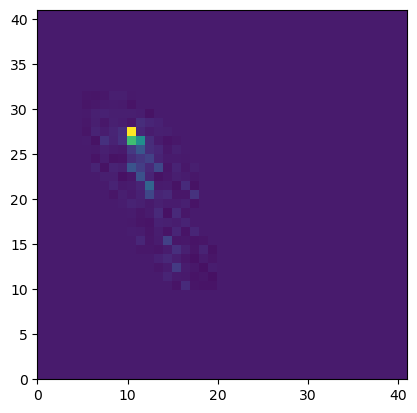

In [9]:
def plot_image(image, name=None):
    fig, ax = plt.subplots(1)
    ax.set_aspect(1)
    ax.pcolor(np.flip(image[:, :, 0], axis=(0)), cmap='viridis', vmin=-5)
    plt.show()
    fig.savefig("./binned_image%s.png" % name)


def re_index_ct14(image):
    return image[5:, :, :]

plot_image(mapped_images_2[11],name="test2023-07-18")

In [6]:
num_events = 100
mapped_images_1 = np.empty((num_events, 41,41,1))
mapped_images_2 = np.empty((num_events, 41,41,1))
mapped_images_3 = np.empty((num_events, 41,41,1))
mapped_images_4 = np.empty((num_events, 41,41,1))
mapped_labels = np.empty(num_events)

#labelsg = np.stack([data[2] for data in tel1g_raw])
#labelsg_ones = np.ones_like(labelsg)

# Using the map_image function for mapping the data from the different telescopes to the associated empty array
# Drawing radom num_events events from all the data 
length = num_events
max_value = len(tel1)
#random_list = random.sample(range(max_value),length) 
random_list = np.random.randint(max_value, size=length)
image_nr = 0
'''
print("Start Mapping...")
for event_nr in random_list:
    test_pixel_values_1 = np.expand_dims(tel1[event_nr], axis=1)
    mapped_images_1[image_nr] = default_mapper.map_image(test_pixel_values_1, 'HESS-I')
    test_pixel_values_2 = np.expand_dims(tel2[event_nr], axis=1)
    mapped_images_2[image_nr] = default_mapper.map_image(test_pixel_values_2, 'HESS-I')
    test_pixel_values_3 = np.expand_dims(tel3[event_nr], axis=1)
    mapped_images_3[image_nr] = default_mapper.map_image(test_pixel_values_3, 'HESS-I')        
    test_pixel_values_4 = np.expand_dims(tel4[event_nr], axis=1)
    mapped_images_4[image_nr] = default_mapper.map_image(test_pixel_values_4, 'HESS-I')
    mapped_labels[image_nr] = labels[event_nr]
    image_nr=image_nr+1

print("... Finished Mapping")
'''

print("Start Mapping...")
for event_nr in random_list:
    #test_pixel_values_1 = np.expand_dims(tel1[event_nr], axis=1)
    mapped_images_1[image_nr] = ct_14_mapper.map_image(tel1[event_nr][3][:, np.newaxis], 'HESS-I')
    #mapped_images_1 = re_index_ct14(mapped_images_1)
    #test_pixel_values_2 = np.expand_dims(tel2[event_nr][3][:, np.newaxis], axis=1)
    #mapped_images_2[image_nr] = ct_14_mapper.map_image(tel2g_raw[event_nr][3][:, np.newaxis], 'HESS-I')
    mapped_images_2[image_nr] = ct_14_mapper.map_image(tel2[event_nr][3][:, np.newaxis], 'HESS-I')
    #mapped_images_2 = re_index_ct14(mapped_images_2)
    #test_pixel_values_3 = np.expand_dims(tel3[event_nr][3][:, np.newaxis], axis=1)
    mapped_images_3[image_nr] = ct_14_mapper.map_image(tel3[event_nr][3][:, np.newaxis], 'HESS-I')   
    #mapped_images_3 = re_index_ct14(mapped_images_3)     
    #test_pixel_values_4 = np.expand_dims(tel4[event_nr][3][:, np.newaxis], axis=1)
    mapped_images_4[image_nr] = ct_14_mapper.map_image(tel4[event_nr][3][:, np.newaxis], 'HESS-I')
    #mapped_images_4 = re_index_ct14(mapped_images_4)
    mapped_labels[image_nr] = labels[event_nr]
    image_nr=image_nr+1

print("... Finished Mapping")

mapped_images = np.array([mapped_images_1,mapped_images_2,mapped_images_3,mapped_images_4])
print(np.shape(mapped_images_1))
print(np.shape(mapped_images))

# Reshape the final array, so it is present in the same way as MoDAII data
#mapped_images = np.transpose(mapped_images, (1, 0, 2, 3, 4))
#mapped_images = np.squeeze(mapped_images, axis=-1)
mapped_labels = mapped_labels[:,np.newaxis]

print(np.shape(mapped_images))
print(np.shape(mapped_labels))




Start Mapping...
... Finished Mapping
(100, 41, 41, 1)
(4, 100, 41, 41, 1)
(4, 100, 41, 41, 1)
(100, 1)


In [7]:
mapped_images = mapped_images_1 # np.array([mapped_images_1,mapped_images_2,mapped_images_3,mapped_images_4])
print(np.shape(mapped_images_1))
print(np.shape(mapped_images))

# Reshape the final array, so it is present in the same way as MoDAII data
#mapped_images = np.transpose(mapped_images, (1, 0, 2, 3, 4))
mapped_images = np.squeeze(mapped_images, axis=-1)
mapped_labels = mapped_labels[:,np.newaxis]

print(np.shape(mapped_images))
print(np.shape(mapped_labels))

peak_times = mapped_images
event_labels = mapped_labels

# some reshaping for the further use of the timing data in the CNN
peak_times = peak_times.reshape((*np.shape(peak_times),1))

# overview about the important data array for later usage
print(np.shape(peak_times)[0], " events with 4 images each are available \n")
print("Shape of 'event_labels': ",np.shape(event_labels))
print("Shape of 'peak_times': ",np.shape(peak_times),"\n")

# split into random training data (80%) and test data (20%)
train_data, test_data, train_labels, test_labels = [], [], [], []
random_selection = np.random.rand(np.shape(peak_times)[0]) <= 0.8
train_data.append(peak_times[random_selection])
test_data.append(peak_times[~random_selection])
train_labels.append(event_labels[random_selection])
test_labels.append(event_labels[~random_selection])


# free some memory space
del peak_times
del event_labels

# convert to numpy array and reshape 
train_data = np.array(train_data)
train_data = train_data.reshape(np.shape(train_data[0]))
test_data = np.array(test_data)
test_data = test_data.reshape(np.shape(test_data[0]))

train_labels = np.array(train_labels)
train_labels = train_labels.reshape(np.shape(train_labels[0]))
test_labels = np.array(test_labels)
test_labels = test_labels.reshape(np.shape(test_labels[0]))

train_labels_multishape = np.zeros_like(train_data)
test_labels_multishape = np.zeros_like(test_data)

len_train = np.shape(train_data)[0]
len_test = np.shape(test_data)[0]

for i in range(0,len_train):
    train_labels_multishape[i,:,:,:] = train_labels[i]

for k in range(0,len_test):
    test_labels_multishape[k,:,:,:] = test_labels[k]

# overvew about the splitting into training and test data
print("Split into Training and Test Data")
print("Train data shape:", np.shape(train_data) , "-->",round(100*len_train/(len_train+len_test),2),"%")
print("Test data shape:", np.shape(test_data), "-->",round(100*len_test/(len_train+len_test),2), "%")
print("Train labels shape:", np.shape(train_labels))
print("Test labels shape:", np.shape(test_labels))

(100, 41, 41, 1)
(100, 41, 41, 1)
(100, 41, 41)
(100, 1, 1)
100  events with 4 images each are available 

Shape of 'event_labels':  (100, 1, 1)
Shape of 'peak_times':  (100, 41, 41, 1) 

Split into Training and Test Data
Train data shape: (89, 41, 41, 1) --> 89.0 %
Test data shape: (11, 41, 41, 1) --> 11.0 %
Train labels shape: (89, 1, 1)
Test labels shape: (11, 1, 1)


In [8]:
global training_generator
global testing_generator

training_generator = MyGenerator(train_data_1,train_data_2,train_data_3,train_data_4,train_labels)
testing_generator = MyGenerator(test_data_1,test_data_2,test_data_3,test_data_4,test_labels)

# Generate data and plot the first batch
batch_index = 0  
training_generator.plot_batch(batch_index)


NameError: name 'MyGenerator' is not defined

In [26]:
print(np.shape(mapped_images))
mapped_images_1a = mapped_images[0]
print(np.shape(mapped_images_1a))
print(np.shape(mapped_images_2))

(4, 100, 41, 41, 1)
(100, 41, 41, 1)
(100, 41, 41, 1)


In [10]:
label4 = train_labels_multishape[:,1,:,:][5].ravel()
print(label4)
print(train_labels_multishape[:,1,:,:][1].ravel())
print(train_labels_multishape[:,1,:,:][10].ravel())
print(train_labels_multishape[:,1,:,:][20].ravel())
print(train_labels_multishape[:,1,:,:][23].ravel())
print(train_labels_multishape[:,1,:,:][4].ravel())
print(train_labels_multishape[:,1,:,:][14].ravel())
print(train_labels_multishape[:,1,:,:][24].ravel())
print(train_labels_multishape[:,1,:,:][24].ravel())
print(train_labels_multishape[:,1,:,:][1].ravel())
print(train_labels_multishape[:,1,:,:][10].ravel())
print(train_labels_multishape[:,1,:,:][20].ravel())
print(train_labels_multishape[:,1,:,:][23].ravel())
print(train_labels_multishape[:,1,:,:][3].ravel())
print(train_labels_multishape[:,1,:,:][13].ravel())
print(train_labels_multishape[:,1,:,:][23].ravel())
print(train_labels_multishape[:,1,:,:][25].ravel())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

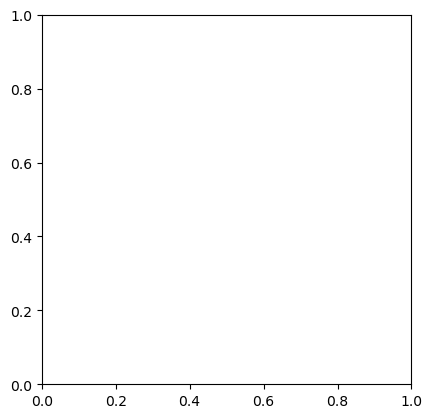

In [11]:
def plot_image(image, name=None):
    fig, ax = plt.subplots(1)
    ax.set_aspect(1)
    ax.pcolor(np.flip(image[:, :, 0], axis=(0)), cmap='viridis', vmin=-5)
    plt.show()
    fig.savefig("./binned_image%s.png" % name)

def plot_image_2by2(image,labels,event_nr):
    image1 = image[:,0,:,:][event_nr]
    image2 = image[:,1,:,:][event_nr]
    image3 = image[:,2,:,:][event_nr]
    image4 = image[:,3,:,:][event_nr]
    fig, ax = plt.subplots(2,2)
    ax[0,0].set_aspect(1)
    ax[0,0].pcolor(np.flip(image1[:,:,0],axis=(0)), cmap='viridis',vmin=-5)
    ax[0,1].set_aspect(1)
    ax[0,1].pcolor(np.flip(image2[:,:,0],axis=(0)), cmap='viridis',vmin=-5)
    ax[1,0].set_aspect(1)
    ax[1,0].pcolor(np.flip(image3[:,:,0],axis=(0)), cmap='viridis',vmin=-5)
    ax[1,1].set_aspect(1)
    ax[1,1].pcolor(np.flip(image4[:,:,0],axis=(0)), cmap='viridis',vmin=-5) 

    label1 = labels[:,0,:,:][event_nr].ravel()[0]
    label2 = labels[:,1,:,:][event_nr].ravel()[0]
    label3 = labels[:,2,:,:][event_nr].ravel()[0]
    label4 = labels[:,3,:,:][event_nr].ravel()[0]

    str_label1 = '{}'.format(label1)
    str_label2 = '{}'.format(label2)
    str_label3 = '{}'.format(label3)
    str_label4 = '{}'.format(label4)

    ax[0, 0].text(0.05, 0.95, str_label1, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[0, 1].text(0.05, 0.95, str_label2, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[1, 0].text(0.05, 0.95, str_label3, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[1, 1].text(0.05, 0.95, str_label4, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))




    plt.show()

def re_index_ct14(image):
    return image[5:, :, :]


plot_image(train_data[50][2], name="ct14")

train_data_1 = train_data[:,2,:,:] 

plot_image(train_data_1[50],name='ct14')
plot_image_2by2(train_data,4)

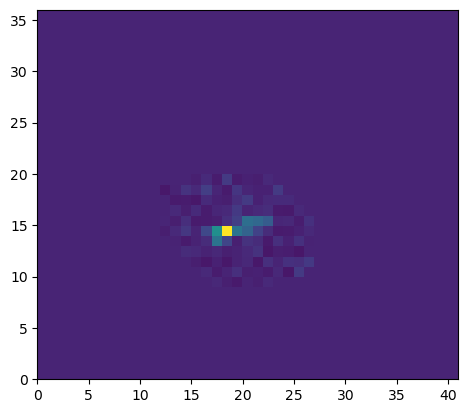

In [9]:
#test_img_ct14 = f["dl1/event/telescope/images/tel_003"][50][3][:, np.newaxis]
#test_img_ct14 = x3[50][3][:,np.newaxis]
#test_img_ct5 = f["dl1/event/telescope/images/tel_005"][1][3][:, np.newaxis]

#test_img_ct14 = np.ones(geo_ct14.pix_id.shape)[:, np.newaxis]
#test_img_ct5 = np.ones(geo_ct5.pix_id.shape)[:, np.newaxis]
#test_img_ct14 = np.arange(geo_ct14.pix_id.shape[0])[:, np.newaxis]
#test_img_ct5 = np.arange(geo_ct5.pix_id.shape[0])[:, np.newaxis]


def plot_image(image, name=None):
    fig, ax = plt.subplots(1)
    ax.set_aspect(1)
    ax.pcolor(np.flip(image[:, :, 0], axis=(0)), cmap='viridis', vmin=-5)
    plt.show()
    fig.savefig("./binned_image%s.png" % name)


def re_index_ct14(image):
    return image[5:, :, :]


#image_ct14 = ct_14_mapper.map_image(test_img_ct14, "HESS-I")
#image_ct14 = re_index_ct14(image_ct14)
plot_image(image_ct14, name="ct14")